<a href="https://colab.research.google.com/github/plue1011/PyTorch/blob/master/practice/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
import json
from PIL import Image
import matplotlib.pyplot as plt

import cv2
import os
import copy
import glob
import re
import pandas as pd

%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optimizers
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision import models

from sklearn.metrics import accuracy_score

# VGG-16の学習済みモデルをロード

In [3]:
# 学習済みのVGG-16モデルをロード

# VGG-16モデルのインスタンスを生成
use_pretrained = True  # 学習済みのパラメータを使用
net = models.vgg16(pretrained=use_pretrained)
net.eval()  # 推論モードに設定

# モデルのネットワーク構成を出力
print(net)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth



VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

# データ作成

## データの読み込み

In [4]:
root_path = '/content/drive/My Drive/study/CNN/dataset/CIFAR10'
train_set = torchvision.datasets.CIFAR10(root=root_path, train=True, download=True)
test_set = torchvision.datasets.CIFAR10(root=root_path, train=False, download=True)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## 飛行機と車だけ抽出

In [0]:
train_set_class01 = []
train_labels = []
for data, label in train_set:
    if label == 0 or label == 1:
        train_set_class01.append(data)
        train_labels.append(label)

test_set_class01 = []
test_labels = []
for data, label in test_set:
    if label == 0 or label == 1:
        test_set_class01.append(data)
        test_labels.append(label)

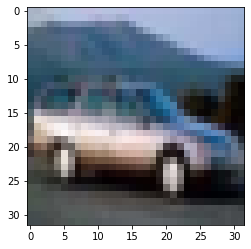

In [6]:
# (32, 32)
plt.imshow(np.array(train_set_class01[0]))
plt.show()

リサイズして、(32, 32)の画像を(300, 300)の画像に変換している

In [0]:
train_set_class01 = [cv2.resize(np.array(data), (300, 300)) for data in train_set_class01]
test_set_class01 = [cv2.resize(np.array(data), (300, 300)) for data in test_set_class01]

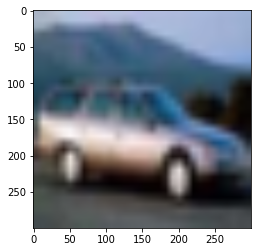

In [8]:
# (300, 300)
plt.imshow(train_set_class01[0])
plt.show()

##  transformの作成

In [0]:
transform = transforms.Compose(
    [transforms.ToTensor(),  # tensor型に変換
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 画像を正規化
    ])

## Datasetの作成

In [0]:
class MyDataset(Dataset):
    def __init__(self, dataset, labels, transform=None):
        self.transform = transform
        self.dataset = dataset
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    # データをtransformで前処理してから返している
    def __getitem__(self, idx):
        out_data = self.dataset[idx]
        out_label =  self.labels[idx]

        if self.transform:
            out_data = self.transform(out_data)

        return out_data, out_label
    
train_dataset = MyDataset(train_set_class01, train_labels, transform)
test_dataset = MyDataset(test_set_class01, test_labels, transform)

## DataLoaderの作成

In [0]:
# 訓練データをさらに「訓練データ」と「検証データ」に分ける(検証データ!=テストデータ)
n_samples = len(train_dataset)
n_train = int(n_samples * 0.8)
n_val = n_samples - n_train
train_dataset, val_dataset = random_split(train_dataset, [n_train, n_val])

train_dataloader = DataLoader(train_dataset, batch_size=50, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=50, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=50, shuffle=False)

In [12]:
train_dataset[0][0].size()

torch.Size([3, 300, 300])

# 簡単なCNN

## モデルの構築

In [0]:
# モデルの構築
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 72 * 72, 4096)
        self.fc2 = nn.Linear(4096, 4096)
        self.fc3 = nn.Linear(4096, 2)

    def forward(self, x):
        # print("0", x.size())
        x = self.pool(F.relu(self.conv1(x)))
        # print("1", x.size())
        x = self.pool(F.relu(self.conv2(x)))
        # print("2", x.size())
        x = x.view(-1, 16 * 72 * 72)
        # print("3", x.size())
        x = F.relu(self.fc1(x))
        # print("4", x.size())
        x = F.relu(self.fc2(x))
        # print("5", x.size())
        x = self.fc3(x)
        # print("6", x.size())
        return x

In [0]:
# モデルの構築
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # cpuかgpuのどちらのデバイスを使っているかを代入する
model = CNN().to(device)

# 誤差関数の定義
compute_loss = nn.CrossEntropyLoss()

# 最適化手法の定義
optimizer = optimizers.Adam(model.parameters(),
                            lr=0.001,
                            betas=(0.9, 0.999), 
                            amsgrad=True)

## 学習

In [0]:
# 関数

## 学習の早期終了
class EarlyStopping:
    '''
    早期終了 (early stopping)
    '''
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def __call__(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print('early stopping')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False

## 1ステップ分の訓練のための関数
def train_step(x, t):
    model.train()  # モデルを訓練モードに設定する
    preds = model(x)  # modelにxを代入して、予測させる
    loss = compute_loss(preds, t)  # 予測値と正解との誤差を求める
    optimizer.zero_grad()  # 勾配を初期化する
    loss.backward()  # 勾配を計算する
    optimizer.step()  # パラメータを更新する
    return loss, preds

## 1ステップ分の訓練のための関数
def val_step(x, t):
    model.eval()  # モデルを評価モードに設定する
    preds = model(x)  # modelにxを代入して、予測させる
    loss = compute_loss(preds, t)  # 予測値と正解との誤差を求める    
    return loss, preds

## テストデータの評価関数
def test_step(x, t):
    return val_step(x, t)

In [22]:
# 学習
## 設定
epochs = 100  # エポック数を設定する
hist = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
es = EarlyStopping(patience=10, verbose=1)  # 10回以上誤差が小さくならないと早期終了する

np.random.seed(123)
torch.manual_seed(123)

## モデルの学習
for epoch in range(epochs):
    train_loss = 0.
    train_acc = 0.
    val_loss = 0.
    val_acc = 0.

    # 訓練パート
    for (x, t) in train_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = train_step(x, t)
        train_loss += loss.item()
        train_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    # 検証パート
    for (x, t) in val_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = val_step(x, t)
        val_loss += loss.item()
        val_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())

    val_loss /= len(val_dataloader)
    val_acc /= len(val_dataloader)

    # 学習状況を保存
    hist['loss'].append(train_loss)
    hist['accuracy'].append(train_acc)
    hist['val_loss'].append(val_loss)
    hist['val_accuracy'].append(val_acc)

    print('epoch: {}, loss: {:.3}, acc: {:.3f}'
          ', val_loss: {:.3}, val_acc: {:.3f}'.format(
              epoch+1,
              train_loss,
              train_acc,
              val_loss,
              val_acc
          ))

    if es(val_loss):
        break        

epoch: 1, loss: 1.12, acc: 0.787, val_loss: 0.404, val_acc: 0.830
epoch: 2, loss: 0.302, acc: 0.870, val_loss: 0.273, val_acc: 0.890
epoch: 3, loss: 0.226, acc: 0.908, val_loss: 0.289, val_acc: 0.890
epoch: 4, loss: 0.163, acc: 0.938, val_loss: 0.329, val_acc: 0.871
epoch: 5, loss: 0.108, acc: 0.959, val_loss: 0.259, val_acc: 0.895
epoch: 6, loss: 0.0578, acc: 0.980, val_loss: 0.298, val_acc: 0.905
epoch: 7, loss: 0.0234, acc: 0.992, val_loss: 0.411, val_acc: 0.906
epoch: 8, loss: 0.0488, acc: 0.982, val_loss: 0.375, val_acc: 0.907


KeyboardInterrupt: ignored

## モデルの評価

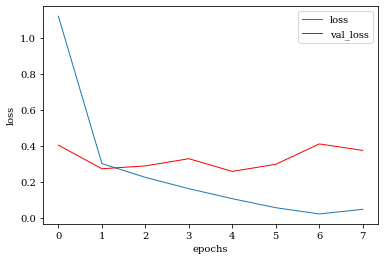

In [25]:
# テストデータの評価関数
def test_step(x, t):
    return val_step(x, t)

# 検証データの誤差の可視化
loss = hist['loss']
val_loss = hist['val_loss']

fig = plt.figure()
plt.rc('font', family='serif')
plt.plot(range(len(loss)), loss, linewidth=1,
             label='loss')
plt.plot(range(len(val_loss)), val_loss,
             color='red', linewidth=1,
             label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## 予測

In [26]:
test_loss = 0.
test_acc = 0.

for (x, t) in test_dataloader:
    x, t = x.to(device), t.to(device)
    loss, preds = test_step(x, t)
    test_loss += loss.item()
    test_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())

test_loss /= len(test_dataloader)
test_acc /= len(test_dataloader)
print('test_loss: {:.3f}, test_acc: {:.3f}'.format(
        test_loss,
        test_acc
))

test_loss: 0.449, test_acc: 0.901


# VGG16(未学習)

## モデルの構築

In [13]:
def make_vgg():
    layers = []
    in_channels = 3  # 色チャネル数

    # vggモジュールで使用する畳み込み層やマックスプーリングのチャネル数
    cfg = [64, 64, 'M', 
           128, 128, 'M', 
           256, 256, 256, 'MC', 
           512, 512, 512, 'M', 
           512, 512, 512]

    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        elif v == 'MC':
            # ceilは出力サイズを、計算結果（float）に対して、切り上げで整数にするモード
            # デフォルトでは出力サイズを計算結果（float）に対して、切り下げで整数にするfloorモード
            layers += [nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v

    pool5 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
    layers += [pool5]
    return nn.ModuleList(layers)

# 動作確認
vgg_test = make_vgg()
print(vgg_test)

ModuleList(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (17): Conv2d(256, 512, kernel_siz

In [0]:
# モデルの構築
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.vgg = make_vgg()

        self.fc1 = nn.Linear(512 * 19 * 19, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 2)

    def forward(self, x):
        for k in range(len(self.vgg)):
            x = self.vgg[k](x)
        x = x.view(-1, 512 * 19 * 19)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [0]:
# モデルの構築
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # cpuかgpuのどちらのデバイスを使っているかを代入する
model = VGG16().to(device)

# 誤差関数の定義
compute_loss = nn.CrossEntropyLoss()

# 最適化手法の定義
optimizer = optimizers.Adam(model.parameters(),
                            lr=0.001,
                            betas=(0.9, 0.999), 
                            amsgrad=True)

## 学習

In [0]:
# 関数

## 学習の早期終了
class EarlyStopping:
    '''
    早期終了 (early stopping)
    '''
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def __call__(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print('early stopping')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False

## 1ステップ分の訓練のための関数
def train_step(x, t):
    model.train()  # モデルを訓練モードに設定する
    preds = model(x)  # modelにxを代入して、予測させる
    loss = compute_loss(preds, t)  # 予測値と正解との誤差を求める
    optimizer.zero_grad()  # 勾配を初期化する
    loss.backward()  # 勾配を計算する
    optimizer.step()  # パラメータを更新する
    return loss, preds

## 1ステップ分の訓練のための関数
def val_step(x, t):
    model.eval()  # モデルを評価モードに設定する
    preds = model(x)  # modelにxを代入して、予測させる
    loss = compute_loss(preds, t)  # 予測値と正解との誤差を求める    
    return loss, preds

## テストデータの評価関数
def test_step(x, t):
    return val_step(x, t)

In [17]:
# 学習
## 設定
epochs = 100  # エポック数を設定する
hist = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
es = EarlyStopping(patience=10, verbose=1)  # 10回以上誤差が小さくならないと早期終了する

np.random.seed(123)
torch.manual_seed(123)

## モデルの学習
for epoch in range(epochs):
    train_loss = 0.
    train_acc = 0.
    val_loss = 0.
    val_acc = 0.

    # 訓練パート
    for (x, t) in train_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = train_step(x, t)
        train_loss += loss.item()
        train_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())

    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)

    # 検証パート
    for (x, t) in val_dataloader:
        x, t = x.to(device), t.to(device)
        loss, preds = val_step(x, t)
        val_loss += loss.item()
        val_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())

    val_loss /= len(val_dataloader)
    val_acc /= len(val_dataloader)

    # 学習状況を保存
    hist['loss'].append(train_loss)
    hist['accuracy'].append(train_acc)
    hist['val_loss'].append(val_loss)
    hist['val_accuracy'].append(val_acc)

    print('epoch: {}, loss: {:.3}, acc: {:.3f}'
          ', val_loss: {:.3}, val_acc: {:.3f}'.format(
              epoch+1,
              train_loss,
              train_acc,
              val_loss,
              val_acc
          ))

    if es(val_loss):
        break        

epoch: 1, loss: 0.691, acc: 0.543, val_loss: 0.627, val_acc: 0.742
epoch: 2, loss: 0.473, acc: 0.780, val_loss: 0.455, val_acc: 0.802
epoch: 3, loss: 0.366, acc: 0.842, val_loss: 0.345, val_acc: 0.844


RuntimeError: ignored

## モデルの評価

In [0]:
# テストデータの評価関数
def test_step(x, t):
    return val_step(x, t)

# 検証データの誤差の可視化
loss = hist['loss']
val_loss = hist['val_loss']

fig = plt.figure()
plt.rc('font', family='serif')
plt.plot(range(len(loss)), loss, linewidth=1,
             label='loss')
plt.plot(range(len(val_loss)), val_loss,
             color='red', linewidth=1,
             label='val_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

## 予測

In [18]:
test_loss = 0.
test_acc = 0.

for (x, t) in test_dataloader:
    x, t = x.to(device), t.to(device)
    loss, preds = test_step(x, t)
    test_loss += loss.item()
    test_acc += accuracy_score(t.tolist(), preds.argmax(dim=-1).tolist())

test_loss /= len(test_dataloader)
test_acc /= len(test_dataloader)
print('test_loss: {:.3f}, test_acc: {:.3f}'.format(
        test_loss,
        test_acc
))

RuntimeError: ignored